In [81]:
import warnings
warnings.filterwarnings(action='ignore')

def kaggle_format(df):
    df['label'][df['label'] == 'none'] = 0
    df['label'][df['label'] == 'offensive'] = 1
    df['label'][df['label'] == 'hate'] = 2
    return df

# 실험일지 01 - 05
- 실혐 : TF-IDF 백터화 , lgs 모델 적용
- 01-03 tfidf max_features 테스트 결과
    - f1-macro 점수 
        - 140000/ 0.568353(1위) >> dev 0.6171, test 0.52893
        - 100000/ 0.567885(3위) >> dev 0.6216, test 0.52899
    - max_features list(range(140000, 150001, 1000))
        - 전부 똑같음
- 01-04 n_gram 값 조정 및 최적의 max_features 찾을 예정
    - n_gram 을 늘려서는 답이 없음
- 전처리를 늘려가며 테스트
    - 띄워쓰기
    - 

### 최고 성적 f1 score 확인

In [82]:
import pandas as pd
# train 데이터 / 7893/ 
# 'none'/ 'offensive'/ 'hate' : 3486/ 2498/ 1909
train = pd.read_csv('total_20210121.csv')
train = train[['comments', 'hate']]
train.columns = ['comments', 'label']
train = kaggle_format(train)
train = train.astype({'label': 'str'})

# dev 데이터 / 471/ 
# 'none'/ 'offensive'/ 'hate' : 160/ 189/ 122
dev = pd.read_csv('./korean-hate-speech-master/labeled/dev.tsv', sep='\t')
dev = dev[['comments', 'hate']]
dev.columns = ['comments', 'label']
dev = kaggle_format(dev)
dev = dev.astype({'label': 'str'})

test = pd.read_csv('./korean-hate-speech-master/test.no_label.tsv', sep='\t')

In [83]:
X, y = train.comments, train.label
X_test, y_test = dev.comments, dev.label

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.0, analyzer='char', ngram_range=(1,3), sublinear_tf=True,
               max_features=100000)
X_tf = tfidf.fit_transform(X, y)
X_dev = tfidf.transform(X_test)

In [85]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1, 
                              class_weight='balanced', 
                              max_iter=6000,
                             random_state=13).fit(X_tf, y)
pred = lr_model.predict(X_dev)

In [86]:
from sklearn.metrics import f1_score

baseline = f1_score(y_test, pred, average='macro')
baseline

0.6171504866913602

### 전처리
- soynlp 패키지사용
    - 반복제거 기능 사용시 ㅋㅋㅋ과 단어가 붙어있는 경우 그단어도 반복으로 포함 제거
        - ex) ㅋㅋ듣보잡 -> ㅋㅋ보잡 / 욕한다는게ㅋㅋㅋㅋㅋㅋ역시 -> 욕한다는ㅋㅋ시
- Okt --> 반복 제거를 위해 ㅋㅋㅋ과 같은것을 띄워야함
    - 그랬을때 부작용은 맞춤법이 지켜지지 않은 데이터다 보니 분류에 오류가 있음
        - ex) 듣보잡 기사내보 장난하냐구 -> 듣보잡 기 사 내 보 장난 하냐구
            - 동영상보니깐가관 -> 동 영 상보 니깐 가관 
- 다시, soynlp를 사용해서 형태 분석 -> 기존 분석기는 신조어에 취약

In [87]:
# 반복 제거 확인
from soynlp.normalizer import *

test = pd.DataFrame()
ls = []
for c in X:
    ment = repeat_normalize(c, num_repeats=1)
    ls.append(ment)

test['comments'] = X
test['soynlp'] = ls

In [88]:
# 반복제거 기능 동작한 문장 확인
dif_idx = test[test.comments != test.soynlp].index

for idx in dif_idx[49:100]:
    print(idx)
    print('원본 : ', test['comments'][idx],'\n반복제거 : ', test['soynlp'][idx], '\n\n')

1334
원본 :  ㅋㅋㅋㅋㅋㅋㅋ애초에 여자들이 왜욕하는데? 성상품화때문아님? 저 기사 댓글에 한남새 기들 성희롱 오지는데 그딴 스 레기짓만 안해도 성상품화한다고 욕먹지 않음 한남들 지들 때문에 욕먹는건 모르고 좋다고 성희롱 오지네 
반복제거 :  ㅋ애초에 여자들이 왜욕하는데? 성상품화때문아님? 저 기사 댓글에 한남새 기들 성희롱 오지는데 그딴 스 레기짓만 안해도 성상품화한다고 욕먹지 않음 한남들 지들 때문에 욕먹는건 모르고 좋다고 성희롱 오지네 


1337
원본 :  너네 댓글 조심해라 그러다 고소당한다 ~ 아무리 그래도 니네 한테 잘못한건 없으니 가려서해 할짓없는것들 남욕은 오지게 조아하지 특히 맘충들 ㅠㅠㅠㅠㅠㅠㅠ 쯧쯧...... 
반복제거 :  너네 댓글 조심해라 그러다 고소당한다 ~ 아무리 그래도 니네 한테 잘못한건 없으니 가려서해 할짓없는것들 남욕은 오지게 조아하지 특히 맘충들 ㅠ 쯧쯧...... 


1367
원본 :  아니 근데.튜닝한사람은 프러포즈받지도.결혼도못함?ㅋㅋㅋ지들은 돈없어서 못하는것들이ㅋㅋㅋㅋ아이고배아퍼죽지ㅋ 
반복제거 :  아니 근데.튜닝한사람은 프러포즈받지도.결혼도못함?ㅋㅋㅋ지들은 돈없어서 못하는것들이ㅋ아이고배아퍼죽지ㅋ 


1374
원본 :  잘나가고 돈많은데 차별하면 어떠냐ㅋㅋㅋㅋㅋ똥양인은 차별당할 만한 외모기도하고ㅎ백인들 찬양하자그냥 
반복제거 :  잘나가고 돈많은데 차별하면 어떠냐ㅋ똥양인은 차별당할 만한 외모기도하고ㅎ백인들 찬양하자그냥 


1381
원본 :  아무리 방탄이 대단하다고 하지만 내년엔 워너원도 없고 과연 시상식장이 꽉 채워질까?ㅋㅋㅋㅋ 
반복제거 :  아무리 방탄이 대단하다고 하지만 내년엔 워너원도 없고 과연 시상식장이 꽉 채워질까?ㅋ 


1387
원본 :  평소엔 현대예술 관심도 없던 아줌마들이 방탄 무대 하나보고 마치 예술,문학에 통달한것처럼 말하는것보면 그냥 같잖고 웃김ㅋㅋㅋㅋㅋ 
반복제거 :  평소엔 현대예술 관심도 없던 아줌마들이 방탄 무대 하나보고 마치 예술,문학에 통달한것처럼 말하는것보면 그냥

In [89]:
# Okt 사용 한것 확인

In [95]:
import kss
from konlpy.tag import Okt
from soynlp.normalizer import *

okt = Okt()
ls = []
for c in X:
    ment = ' '.join(okt.morphs(c)) 
    ls.append(ment)
test['okt'] = ls
# print('원본 : ', sample)
# print(okt.morphs(sample))
# print(kss.split_sentences(sample))

In [97]:
dif_idx = test[test.comments != test.okt].index
print(len(dif_idx))
for idx in dif_idx[49:100]:
    print(idx)
    print('원본 : ', test['comments'][idx],'\nokt : ', test['okt'][idx], '\n\n')

7659
50
원본 :  어우 난 남잔데..저리 마른여자는 좀 징그럽더라 살좀있는여자가 건강미있어보이고 좋음 
okt :  어우 난 남잔 데 .. 저리 마른 여자 는 좀 징그럽더라 살 좀있는 여자 가 건강미 있어 보이 고 좋음 


51
원본 :  태국 가서 머했을까...궁금궁금 
okt :  태국 가서 머 했을까 ... 궁금궁금 


52
원본 :  현아가 눈이 상당히 낮아 ㅋ 
okt :  현아 가 눈 이 상당히 낮아 ㅋ 


53
원본 :  솔직히 내가 연예인 메이크업하고 옷 좀 걸치면 이던이 정도는 가뿐할듯 
okt :  솔직히 내 가 연예인 메이크업 하고 옷 좀 걸치면 이 던 이 정도 는 가뿐할듯 


54
원본 :  회사짤려 욕쳐먹어 쫌있음 개인스케줄 만남소원해져서 이별 할거뻔하고 저것들이 가수냐 댄서지 댄서들 끝은 99프로 새드앤딩 그리고 철이없어도 너무없다 
okt :  회사 짤려 욕 쳐 먹어 쫌있음 개인 스케줄 만남소 원해져서 이별 할거 뻔하고 저 것 들 이 가수 냐 댄서 지 댄서 들 끝 은 99 프로 새드앤딩 그리고 철 이 없어도 너무 없다 


55
원본 :  얘네 근데 너무 오바들 떨긴하네 ㅋㅋㅋ 이해가 간다 소속사가 슬슬 
okt :  얘 네 근데 너무 오 바 들 떨긴하네 ㅋㅋㅋ 이해 가 간다 소속사 가 슬슬 


56
원본 :  이던이 인기를 끌면 무조건 현아는 버려진다. 
okt :  이 던 이 인기 를 끌 면 무조건 현아 는 버려진다 . 


57
원본 :  이런 걸 왜 찍는걸까? 성관계 동영상 찍는 거랑 같은 거 아닌가? 
okt :  이런 걸 왜 찍는걸 까 ? 성관계 동영상 찍는 거 랑 같은 거 아닌가 ? 


58
원본 :  멋있기만 하구만.이러다 헤어지면 헤어지는거지뭐.연예할때 맘껏 즐기는거 보기 좋은데.내숭보단 훨씬 낫다.화이팅!! 
okt :  멋있기만 하구만 . 이러다 헤어지면 헤어지는거지 뭐 . 연예 할 때 맘껏 즐기는거 보기 좋은데 . 내 숭보 단 훨씬 낫다 . 화이팅 !! 


60
원본 :  ㅋㅋㅋ 생각이라는 걸

In [64]:
sample = X[dif_idx[25]]

print('raw vs 반복제거 vs okt\n')
print('---- 원본 ----')
print(sample)

print('\n---- 반복 제거 적용 후 ----')
repeat = repeat_normalize(sample, num_repeats=2)
print(repeat)

print('\n---- OKT 적용 후 ----')
test = ' '.join(okt.morphs(sample))
print(test)

print('\n---- maxscore_tokenizer ----')
print(' '.join(maxscore_tokenizer.tokenize(sample)) )

print('\n---- OKT - 반복제거 ----')
print(repeat_normalize(test, num_repeats=2))

print('\n---- 반복제거 - OKT ----')
print(' '.join(okt.morphs(repeat)))

print('\n---- OKT - maxscore_tokenizer ----')
print(' '.join(maxscore_tokenizer.tokenize(test)) )

raw vs 반복제거 vs okt

---- 원본 ----
작업물도 잘 안내는데 그놈의 랩퍼딱지는 ㅋㅋㅋㅋㅋㅋㅋㅋ

---- 반복 제거 적용 후 ----
작업물도 잘 안내는데 그놈의 랩퍼딱지는 ㅋㅋ

---- OKT 적용 후 ----
작업 물 도 잘 안내는데 그 놈 의 랩퍼 딱지 는 ㅋㅋㅋㅋㅋㅋㅋㅋ

---- maxscore_tokenizer ----
작업물도 잘 안내는데 그놈의 랩퍼딱지는 ㅋㅋㅋㅋㅋㅋㅋㅋ

---- OKT - 반복제거 ----
작업 물 도 잘 안내는데 그 놈 의 랩퍼 딱지 는 ㅋㅋ

---- 반복제거 - OKT ----
작업 물 도 잘 안내는데 그 놈 의 랩퍼 딱지 는 ㅋㅋ

---- OKT - maxscore_tokenizer ----
작업 물 도 잘 안내는데 그 놈 의 랩퍼 딱지 는 ㅋㅋㅋㅋㅋㅋㅋㅋ


### 다시 전처리
- soynlp로 전처리
    - DoublespaceLineCorpus
    - WordExtractor
    - 띄어쓰기가 잘 되어 있는 경우: L-토큰화
    - 띄어쓰기가 안되어 있는 경우: Max Score 토큰화

In [12]:
okt_ls = []
for c in X:
    okt_ls.append(' '.join(okt.morphs(c)))

In [13]:
okt_ls[:10]

['한남 이지만 명복 은 빌어 드릴께요 ....',
 '울지마 바보 야 ... 나 정말 갠차나',
 '결혼 까지 생각 했어 같은 집 같 은방 에서 슬퍼도 bye bye bye ~~~~#',
 '에이미 물귀신 작전 이 휘 ( 발 ) 성 이벤트 면 좋겠는데 ...',
 '아무튼 여자 조심하자 한순간 에 인생 쫑 난 다',
 '케이윌 목소리 나 창법 너무 올 드하 지 않나 콘서트 도 하네',
 '에이미 제발 조용히 사세요 .. 다른 사람 에게 피 해주지마라 .. 너 로 인하여 아무 이유 없이 피 해보게 하지마 .. 재수앖 네',
 '이래서 여자 는 상종 하면 안 돼 ..... 시기 질투 ... 이제 와 서 ㅈㄹ 이야 ... 안고가기로 했으면 잘살게 내버려 두지 ...',
 '에이미 .. 넘 이상한것 같음 ..',
 '우리 화사 언 냐 는 걸 크지만 저 효린 은 여우 짓 이라구 욧 !!!!']

In [122]:
from soynlp.word import WordExtractor
from soynlp.utils import DoublespaceLineCorpus

word_extractor = WordExtractor(
    min_frequency=100, # example
    min_cohesion_forward=0.05,
    min_right_branching_entropy=0.0
)

word_extractor.train(X)
words = word_extractor.extract()
cohesion_score = {word:score.cohesion_forward for word, score in words.items()}

training was done. used memory 0.591 Gbry 0.574 Gb
all cohesion probabilities was computed. # words = 111
all branching entropies was computed # words = 7463
all accessor variety was computed # words = 7463


In [123]:
# 비교
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=cohesion_score)
ls = []
for c in X:
    #c = repeat_normalize(c, num_repeats=2)
    ment = ' '.join(maxscore_tokenizer.tokenize(c)) 
    ls.append(ment)
test['max'] = ls

In [124]:
test

,comments,soynlp,okt,max
0,한남이지만 명복은 빌어드릴께요....,한남이지만 명복은 빌어드릴께요....,한남 이지만 명복 은 빌어 드릴께요 ....,한남이지만 명복은 빌어드릴께요 .. ..
1,울지마 바보야...나 정말 갠차나,울지마 바보야...나 정말 갠차나,울지마 바보 야 ... 나 정말 갠차나,울지마 바보야 .. .나 정말 갠차나
2,결혼까지 생각했어 같은집 같은방에서 슬퍼도 bye bye bye~~~~#,결혼까지 생각했어 같은집 같은방에서 슬퍼도 bye bye bye~~~~#,결혼 까지 생각 했어 같은 집 같 은방 에서 슬퍼도 bye bye bye ~~~~#,결혼 까지 생각 했어 같은 집 같은 방에서 슬퍼도 bye bye bye~~~~#
3,에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데...,에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데...,에이미 물귀신 작전 이 휘 ( 발 ) 성 이벤트 면 좋겠는데 ...,에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데 .. .
4,아무튼 여자조심하자한순간에 인생쫑난다,아무튼 여자조심하자한순간에 인생쫑난다,아무튼 여자 조심하자 한순간 에 인생 쫑 난 다,아무튼 여자 조심하자한순간에 인생쫑난다
...,...,...,...,...
7888,프듀출신이면 롤모델로 워너원 말했어야지 요즘 더 잘나가는 것도 워너원이고,프듀출신이면 롤모델로 워너원 말했어야지 요즘 더 잘나가는 것도 워너원이고,프듀 출신 이 면 롤모델 로 워 너 원 말 했어야지 요즘 더 잘나가는 것 도 워 너...,프듀출신이면 롤모델로 워너원 말했어야지 요즘 더 잘나가는 것도 워너원이고
7889,10년차방탄팬인데 우리방탄처럼 성공은못하겠지만 일단 방탄의 부하가되고싶다는거니 이름...,10년차방탄팬인데 우리방탄처럼 성공은못하겠지만 일단 방탄의 부하가되고싶다는거니 이름...,10년 차방탄팬인데 우리 방탄 처럼 성공 은 못 하겠지만 일단 방탄 의 부하 가 되...,10년차방탄팬인데 우리방탄처럼 성공은못하겠지만 일단 방탄의 부하가되고싶다는거니 이름...
7890,"엑소는 범접할 수 없는 아이돌계의 신같은 존재라 감히 말도 못꺼내고, 그나마 방탄은...","엑소는 범접할 수 없는 아이돌계의 신같은 존재라 감히 말도 못꺼내고, 그나마 방탄은...",엑소 는 범접 할 수 없는 아이돌 계 의 신 같은 존재 라 감히 말 도 못 꺼내고 ...,"엑소는 범접할 수 없는 아이 돌계의 신 같은 존재라 감히 말도 못꺼내고, 그나마 방..."
7891,워너원이 나와야지. .,워너원이 나와야지. .,워 너 원 이 나와야지 . .,워너원이 나와야지. .


In [125]:
dif_idx2 = test[test['comments'] != test['max']].index
print(len(dif_idx2))
for idx in dif_idx2[0:50]:
    print(idx)
    print('원본 : ', test['comments'][idx],'\nmax : ', test['max'][idx], '\n\n')


5395
0
원본 :  한남이지만 명복은 빌어드릴께요.... 
max :  한남이지만 명복은 빌어드릴께요 .. .. 


1
원본 :  울지마 바보야...나 정말 갠차나 
max :  울지마 바보야 .. .나 정말 갠차나 


2
원본 :  결혼까지 생각했어 같은집 같은방에서 슬퍼도 bye bye bye~~~~# 
max :  결혼 까지 생각 했어 같은 집 같은 방에서 슬퍼도 bye bye bye~~~~# 


3
원본 :  에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데... 
max :  에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데 .. . 


4
원본 :  아무튼 여자조심하자한순간에 인생쫑난다 
max :  아무튼 여자 조심하자한순간에 인생쫑난다 


5
원본 :  케이윌 목소리나 창법 너무 올드하지않나 콘서트도 하네 
max :  케이윌 목소리나 창법 너무 올드 하지 않나 콘서트도 하네 


6
원본 :  에이미 제발 조용히 사세요..다른 사람에게 피해주지마라..너로 인하여 아무 이유없이 피해보게 하지마..재수앖네 
max :  에이미 제발 조용히 사세요 .. 다른 사람 에게 피해주지마라 .. 너로 인하여 아무 이유없이 피해보게 하지 마 .. 재수앖네 


7
원본 :  이래서 여자는 상종하면 안돼.....시기 질투...이제와서 ㅈㄹ 이야...안고가기로했으면 잘살게 내버려두지... 
max :  이래서 여자 는 상종하면 안돼 .. .. .시기 질투 .. . 이제 와서 ㅈㄹ 이야 .. .안고가기로했으면 잘살게 내버려두지 .. . 


8
원본 :  에이미.. 넘 이상한것 같음.. 
max :  에이미 .. 넘 이상한것 같음 .. 


9
원본 :  우리 화사언냐는 걸크지만 저 효린은 여우짓이라구욧!!!! 
max :  우리 화사언냐는 걸크지만 저 효린은 여우짓이라구욧!!! ! 


10
원본 :  얼마나 압도했으면 이런 기사도 나왔겠어ㅋ효린 이쁘기만하구만 연예대상 측도 효린이 이런 스타일의 무대하는 거를 몰라서 불렀겠냐아침부터 왜들 유난인지 어휴

In [130]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
ls = []
for c in X:
    #c = repeat_normalize(c, num_repeats=2)
    ment = ' '.join(tokenizer.tokenize(c)) 
    ls.append(ment)
test['reg'] = ls

In [131]:
dif_idx2 = test[test['comments'] != test['reg']].index
print(len(dif_idx2))
for idx in dif_idx2[0:50]:
    print(idx)
    print('원본 : ', test['comments'][idx],'\nmax : ', test['reg'][idx], '\n\n')

5253
0
원본 :  한남이지만 명복은 빌어드릴께요.... 
max :  한남이지만 명복은 빌어드릴께요 .... 


1
원본 :  울지마 바보야...나 정말 갠차나 
max :  울지마 바보야 ... 나 정말 갠차나 


2
원본 :  결혼까지 생각했어 같은집 같은방에서 슬퍼도 bye bye bye~~~~# 
max :  결혼까지 생각했어 같은집 같은방에서 슬퍼도 bye bye bye ~~~~# 


3
원본 :  에이미 물귀신 작전이 휘(발)성 이벤트면 좋겠는데... 
max :  에이미 물귀신 작전이 휘 ( 발 ) 성 이벤트면 좋겠는데 ... 


6
원본 :  에이미 제발 조용히 사세요..다른 사람에게 피해주지마라..너로 인하여 아무 이유없이 피해보게 하지마..재수앖네 
max :  에이미 제발 조용히 사세요 .. 다른 사람에게 피해주지마라 .. 너로 인하여 아무 이유없이 피해보게 하지마 .. 재수앖네 


7
원본 :  이래서 여자는 상종하면 안돼.....시기 질투...이제와서 ㅈㄹ 이야...안고가기로했으면 잘살게 내버려두지... 
max :  이래서 여자는 상종하면 안돼 ..... 시기 질투 ... 이제와서 ㅈㄹ 이야 ... 안고가기로했으면 잘살게 내버려두지 ... 


8
원본 :  에이미.. 넘 이상한것 같음.. 
max :  에이미 .. 넘 이상한것 같음 .. 


9
원본 :  우리 화사언냐는 걸크지만 저 효린은 여우짓이라구욧!!!! 
max :  우리 화사언냐는 걸크지만 저 효린은 여우짓이라구욧 !!!! 


10
원본 :  얼마나 압도했으면 이런 기사도 나왔겠어ㅋ효린 이쁘기만하구만 연예대상 측도 효린이 이런 스타일의 무대하는 거를 몰라서 불렀겠냐아침부터 왜들 유난인지 어휴 
max :  얼마나 압도했으면 이런 기사도 나왔겠어 ㅋ 효린 이쁘기만하구만 연예대상 측도 효린이 이런 스타일의 무대하는 거를 몰라서 불렀겠냐아침부터 왜들 유난인지 어휴 


11
원본 :  통장에 십원밖에 없나? 시집가고 드라마도 안팔리고 .어쩌누 
max :  통장

### 전처리후 f1-score  단순 비교 
- 1. soynlp 반복제거 repeat_normalize
    - 1.1 soynlp 반복제거 - okt 형태소 --> 부질없음
- 2. okt 형태소 적용
    - 2.1 okt - soynlp 반복제거
- 3. soynlp MaxScoreTokenizer
    - 3.1 soynlp MaxScoreTokenizer - okt  
- 4. 3다 합쳐서
    - 3 - 1
    - 3 - 2 - 1

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

dev = pd.read_csv('./korean-hate-speech-master/labeled/dev.tsv', sep='\t')
dev = dev[['comments', 'hate']]
dev.columns = ['comments', 'label']
dev = kaggle_format(dev)
dev = dev.astype({'label': 'str'})
X_test, y_test = dev.comments, dev.label

def get_f1_score(pre_data):
    vec = TfidfVectorizer(min_df=0.0, analyzer='char', ngram_range=(1,3), sublinear_tf=True,
               max_features=100000)
    X_tf = vec.fit_transform(pre_data)
    print(X_tf.shape)
    lgs = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1, 
                         class_weight='balanced', 
                         max_iter=6000, random_state=10)
    lgs.fit(X_tf, y)
    X_test_tf = vec.transform(X_test)
    pred =  lgs.predict(X_test_tf)
    return f1_score(y_test, pred, average='macro')

In [17]:
scores, scores_h = [], [] 

In [18]:
# 1
ls = []
for c in X:
    ls.append(repeat_normalize(c, num_repeats=2))

score_soynlp = get_f1_score(ls)

scores.append(score_soynlp)
scores_h.append('repeat_normalize')

print('baseline : ', baseline)
print('repeat_normalize : ', score_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
repeat_normalize :  0.6192400765926616


In [19]:
# 2
ls = []
for c in X:
    ls.append(' '.join(okt.morphs(c)))
score_okt = get_f1_score(ls)

scores.append(score_okt)
scores_h.append('okt')

print('baseline : ', baseline)
print('okt : ', okt)

(7893, 99974)
baseline :  0.6171504866913602
okt :  <konlpy.tag._okt.Okt object at 0x00000204D33B3808>


In [20]:
# 2-1
ls = []
for c in X:
    c2 = ' '.join(okt.morphs(c))
    ls.append(repeat_normalize(c2, num_repeats=2))

score_okt_soynlp = get_f1_score(ls)

scores.append(score_okt_soynlp)
scores_h.append('okt--repeat_normalize')

print('baseline : ', baseline)
print('okt - soynlp : ', score_okt_soynlp)

(7893, 99969)
baseline :  0.6171504866913602
okt - soynlp :  0.5755498911931505


In [21]:
# 3
ls = []
for c in X:
    ls.append(' '.join(maxscore_tokenizer.tokenize(c)))
score_tok = get_f1_score(ls)

scores.append(score_tok)
scores_h.append('maxscore_tokenizer')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer : ', score_tok)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer :  0.618094549129032


In [22]:
# 3-1
ls = []
for c in X:
    c2 = ' '.join(maxscore_tokenizer.tokenize(c))
    ls.append(' '.join(okt.morphs(c2)))
score_tok_okt = get_f1_score(ls)

scores.append(score_tok_okt)
scores_h.append('maxscore_tokenizer--okt')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - okt : ', score_tok_okt)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - okt :  0.5802087234770893


In [23]:
# 4 : 3 - 1
ls = []
for c in X:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))
score_tok_soynlp = get_f1_score(ls)

scores.append(score_tok_soynlp)
scores_h.append('repeat_normalize--maxscore_tokenizer')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score_tok_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6254578916861416


In [24]:
# 4-1 : 3 - 2 - 1
ls = []
for c in X:
    c2 = ' '.join(maxscore_tokenizer.tokenize(c))
    c3 = ' '.join(okt.morphs(c2))
    ls.append(repeat_normalize(c3, num_repeats=2))
score_tok_okt_soynlp = get_f1_score(ls)

scores.append(score_tok_okt_soynlp)
scores_h.append('maxscore_tokenizer--okt--repeat_normalize')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - okt - 반복 제거 : ', score_tok_okt_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - okt - 반복 제거 :  0.5802087234770893


In [128]:
# 5 : 특별 케이스
ls = []
for c in X:
    c = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c)))
score_tok_okt_soynlp = get_f1_score(ls)

scores.append(score_tok_okt_soynlp)
scores_h.append('score--maxscore_tokenizer')
print('baseline : ', baseline)
print('score MaxScoreTokenizer : ', score_tok_okt_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
score MaxScoreTokenizer :  0.6006629623112639


In [135]:
# 5 : 특별 케이스
ls = []
for c in X:
    ls.append(' '.join(tokenizer.tokenize(c)))
score_tok = get_f1_score(ls)

scores.append(score_tok_okt_soynlp)
scores_h.append('score--maxscore_tokenizer')
print('baseline : ', baseline)
print('score MaxScoreTokenizer : ', score_tok)

(7893, 100000)
baseline :  0.6171504866913602
score MaxScoreTokenizer :  0.5977665925361016


In [25]:
# 결과 : score_tok_soynlp 0.625458(dev/ f1) 0.53271(kaggle)
df = pd.DataFrame({'score': scores, 'test': scores_h})
df

,score,test
0,0.619240,repeat_normalize
1,0.573148,okt
2,0.575550,okt--repeat_normalize
3,0.618095,maxscore_tokenizer
4,0.580209,maxscore_tokenizer--okt
5,0.625458,repeat_normalize--maxscore_tokenizer
6,0.580209,maxscore_tokenizer--okt--repeat_normalize


In [26]:
df.sort_values(by='score', ascending=False)

,score,test
5,0.625458,repeat_normalize--maxscore_tokenizer
0,0.619240,repeat_normalize
3,0.618095,maxscore_tokenizer
4,0.580209,maxscore_tokenizer--okt
6,0.580209,maxscore_tokenizer--okt--repeat_normalize
2,0.575550,okt--repeat_normalize
1,0.573148,okt


### f1-score가 높았던 2개를 올려봅니다.

In [144]:
def get_test(df, X_train):
    vec = TfidfVectorizer(min_df=0.0, analyzer='char', ngram_range=(1,3), sublinear_tf=True,
               max_features=100000)
    X_tf = vec.fit_transform(X_train)
    print(X_tf.shape)
    lgs = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.9, 
                         class_weight='balanced', 
                         max_iter=6000, random_state=10).fit(X_tf, y)
    X_test_tf = vec.transform(df['comments'])
    df['label'] = lgs.predict(X_test_tf)
    return df

In [145]:
ls = []
for c in X:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))

In [147]:
test = pd.read_csv('./korean-hate-speech-master/test.no_label.tsv', sep='\t')
test_df = get_test(test, ls)
test_df.to_csv('score_tok_soynlp.csv', index=False)

(7893, 100000)


### 그러면 똑같은 방식이지만 음...
- 문자 길이가 짧은것은 날리도록
- kss 적용해 볼것

In [149]:
X_lens = [len(c) for c in X]
len(X_lens)

7893

38.70923603192703


(array([1870., 2060., 1334.,  924.,  583.,  380.,  318.,  210.,  162.,
          52.]),
 array([  4. ,  17.1,  30.2,  43.3,  56.4,  69.5,  82.6,  95.7, 108.8,
        121.9, 135. ]),
 <BarContainer object of 10 artists>)

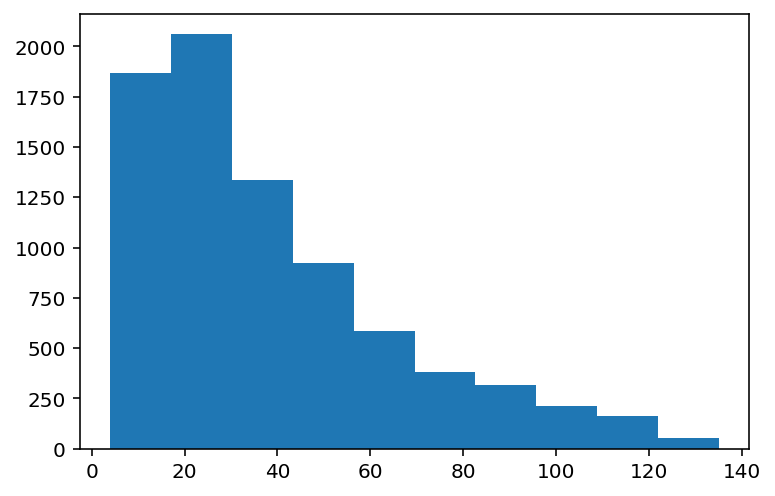

In [151]:
import matplotlib.pyplot as plt
print(np.mean(X_lens))
plt.hist(X_lens)

#### 문자 10개 미만 날렸을 때 --> 0.6030

In [ ]:
def get_f1_score(pre_data, y):
    vec = TfidfVectorizer(min_df=0.0, analyzer='char', ngram_range=(1,3), sublinear_tf=True,
               max_features=100000)
    X_tf = vec.fit_transform(pre_data)
    print(X_tf.shape)
    lgs = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1, 
                         class_weight='balanced', 
                         max_iter=6000, random_state=10)
    lgs.fit(X_tf, y)
    X_test_tf = vec.transform(X_test)
    pred =  lgs.predict(X_test_tf)
    return f1_score(y_test, pred, average='macro')

In [168]:
# 10자 미만 날리고
idx_ls = []
for idx in range(len(X)):
    if len(train['comments'][idx]) > 10:
        idx_ls.append(idx)
        
train_10 = train.iloc[idx_ls]
X_10, y_10 = train_10.comments, train_10.label

In [187]:
get_f1_score(X_10, y_10)

(7264, 100000)


0.6013859361596164

In [170]:
# 추가 전처리 이후 결과
ls = []
for c in X_10:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))
score_tok_soynlp_10 = get_f1_score(ls, y_10)

scores.append(score_tok_soynlp_10)
scores_h.append('score_tok_soynlp_10')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score_tok_soynlp_10)

(7264, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6030696351851449


In [189]:
# 8자 미만 날리고
idx_ls = []
for idx in range(len(X)):
    if len(train['comments'][idx]) > 8:
        idx_ls.append(idx)
        
train_8 = train.iloc[idx_ls]
X_8, y_8 = train_8.comments, train_8.label
print(len(X_8))
get_f1_score(X_8, y_8)

7567
(7567, 100000)


0.6140271731407919

In [181]:
ls = []
for c in X_8:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))
score_tok_soynlp_8 = get_f1_score(ls, y_8)

scores.append(score_tok_soynlp_8)
scores_h.append('score_tok_soynlp_8')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score_tok_soynlp_8)

(7567, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6124161341069015


In [190]:
# 5자 미만 날리고
idx_ls = []
for idx in range(len(X)):
    if len(train['comments'][idx]) > 5:
        idx_ls.append(idx)
        
train_5 = train.iloc[idx_ls]
X_5, y_5 = train_5.comments, train_5.label
print(len(X_5))
get_f1_score(X_5, y_5)

7860
(7860, 100000)


0.6145343114010919

In [183]:
ls = []
for c in X_5:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))
score_tok_soynlp_5 = get_f1_score(ls, y_5)

scores.append(score_tok_soynlp_5)
scores_h.append('score_tok_soynlp_5')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score_tok_soynlp_5)

(7860, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6182984374314718


In [198]:
# 5자 미만 날리고
idx_ls = []
for idx in range(len(X)):
    if len(train['comments'][idx]) > 15:
        idx_ls.append(idx)
        
train_15 = train.iloc[idx_ls]
X_15, y_15 = train_15.comments, train_15.label
print(len(X_15))
get_f1_score(X_15, y_15)

6407
(6407, 100000)


0.599005029125511

#### 띄워쓰기 kss

In [199]:
import kss

test = pd.DataFrame()
ls = []
for c in X:
    ls.append(' '.join(kss.split_sentences(c)))
test['comments'] = X
test['kss'] = ls

In [196]:
test[test.comments != test.kss]

,comments,kss
6,에이미 제발 조용히 사세요..다른 사람에게 피해주지마라..너로 인하여 아무 이유없이...,에이미 제발 조용히 사세요.. 다른 사람에게 피해주지마라.. 너로 인하여 아무 이유...
21,기자앙반아 명품이란말 올려놓구 착한 이진이 뭔잘못이 있다고욕을먹게하냐? 실수했다기레기야,기자앙반아 명품이란말 올려놓구 착한 이진이 뭔잘못이 있다고욕을먹게하냐? 실수했다 기레기야
43,그냥 전라도사람들이 예민한듯 저발언을 부산에서 했다생각해봐 그냥 웃어 넘겼음,그냥 전라도사람들이 예민한듯 저발언을 부산에서 했다 생각해봐 그냥 웃어 넘겼음
49,너무 싸보이는 느낌..살려고 발버둥치는것 같긴한데...좀 안타깝군요싸이는 어쩔려고...,너무 싸보이는 느낌..살려고 발버둥치는것 같긴한데...좀 안타깝군요 싸이는 어쩔려고...
51,태국 가서 머했을까...궁금궁금,태국 가서 머했을까... 궁금궁금
...,...,...
7855,정신적으로이상자들 왜이렇게까지 살을빼는거지?문제다,정신적으로이상자들 왜이렇게까지 살을빼는거지? 문제다
7861,건강하게 다이어트하셔서 더보기좋은듯합니당ㅋ넘이쁘심!! 복면가왕한번더출연하세요~~아무...,건강하게 다이어트하셔서 더보기좋은듯합니당ㅋ넘이쁘심!! 복면가왕한번더출연하세요~~ 아...
7864,왜 연예인이 다이어트 성공한거나 임 신한걸 뉴스 기사로 봐야하는거지 대단한건가?몇달...,왜 연예인이 다이어트 성공한거나 임 신한걸 뉴스 기사로 봐야하는거지 대단한건가? 몇...
7869,음주운전 또 면죄부? 미친 방송국 놈들. 호란이야 아쉬웠겠지만 시청자는 아쉽지 않은...,음주운전 또 면죄부? 미친 방송국 놈들. 호란이야 아쉬웠겠지만 시청자는 아쉽지 않은...


In [197]:
get_f1_score(test['kss'], y)

(7893, 100000)


0.6247941204142539

In [200]:
test = pd.read_csv('./korean-hate-speech-master/test.no_label.tsv', sep='\t')
test_df = get_test(test, ls)
test_df.to_csv('score_tok_soynlp.csv', index=False)

(7893, 100000)


In [191]:
ls = []
for c in test['kss']:
    c2 = repeat_normalize(c, num_repeats=2)
    ls.append(' '.join(maxscore_tokenizer.tokenize(c2)))
score__kss_tok_soynlp = get_f1_score(ls, y)

scores.append(score__kss_tok_soynlp)
scores_h.append('score__kss_tok_soynlp')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score__kss_tok_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6182984374314718


In [192]:
ls = []
for c in X:
    c2 = repeat_normalize(c, num_repeats=2)
    c3 = ' '.join(maxscore_tokenizer.tokenize(c2))
    ls.append(' '.join(kss.split_sentences(c3)))
score__kss_tok_soynlp = get_f1_score(ls, y)

scores.append(score__kss_tok_soynlp)
scores_h.append('score__kss_tok_soynlp')
print('baseline : ', baseline)
print('soynlp MaxScoreTokenizer - 반복 제거 : ', score__kss_tok_soynlp)

(7893, 100000)
baseline :  0.6171504866913602
soynlp MaxScoreTokenizer - 반복 제거 :  0.6230257738183211


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer



vec = TfidfVectorizer(min_df=0.0, analyzer='char', ngram_range=(1,3), 
                      sublinear_tf=True, max_features=10000)
X_tf = vec.fit_transform(X)
print(X_tf.shape)

NameError: name 'X' is not defined

In [205]:
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1, 
                     class_weight='balanced', 
                     max_iter=6000, random_state=10)
lgs.fit(X_tf, y)
X_test_tf = vec.transform(X_test)
pred =  lgs.predict(X_test_tf)

In [206]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average='macro')

0.5910663394900268